In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso,LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

read in data

In [3]:
train=pd.read_csv("/kaggle/input/trainsub/train.csv")
test=pd.read_csv("/kaggle/input/test1-ames/test.csv")

Before we start making big changes lets check for outliers to drop

In [4]:
train.describe()

,Unnamed: 0,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,1538.000000,1538.000000,1.538000e+03,1538.000000,1285.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,...,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000
mean,1024.970741,1469.562419,7.118700e+08,56.983095,69.378210,9955.676203,6.109883,5.559818,1971.860858,1984.168401,...,94.012354,47.527308,22.126138,2.618986,16.298440,2.569571,58.338101,6.177503,2007.776983,181061.993498
std,588.860047,840.814349,1.886513e+08,43.217246,24.095542,5427.477335,1.428502,1.100363,30.173843,20.926357,...,124.893497,66.927900,60.058850,26.147481,57.023537,38.947031,623.083653,2.698290,1.305238,79552.718835
min,0.000000,1.000000,5.263011e+08,20.000000,21.000000,1476.000000,1.000000,1.000000,1872.000000,1950.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,13100.000000
25%,522.250000,748.250000,5.284562e+08,20.000000,58.000000,7473.000000,5.000000,5.000000,1954.000000,1965.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129925.000000
50%,1022.000000,1483.500000,5.354511e+08,50.000000,68.000000,9487.500000,6.000000,5.000000,1975.000000,1993.000000,...,0.000000,26.500000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162250.000000
75%,1528.750000,2189.750000,9.071308e+08,70.000000,80.000000,11498.000000,7.000000,6.000000,2001.000000,2003.750000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213000.000000
max,2050.000000,2930.000000,9.241510e+08,190.000000,313.000000,63887.000000,10.000000,9.000000,2010.000000,2010.000000,...,870.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


Sale Price, BsmtFin SF 1, Total Bsmt SF, 1st Flr SF, look like they might got some outliers going on, lets boxplot to see, and then drop these skewing bad boys.

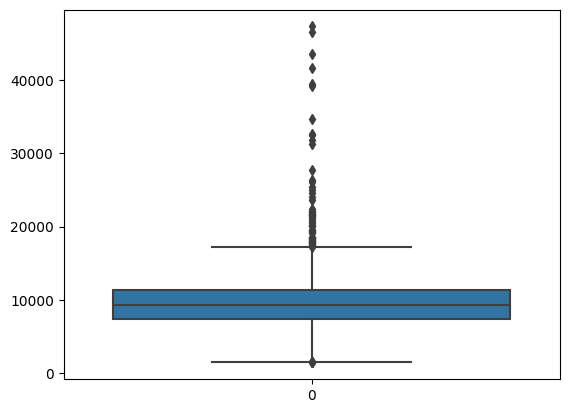

In [8]:
sns.boxplot(train["Lot Area"]);
# sns.boxplot(train["BsmtFin SF 1"])
# sns.boxplot(train["Total Bsmt SF"])
# sns.boxplot(train["1st Flr SF"])
# plt.ylim(200000,600000);
#just doing some visualizations for spotting outliers in this cell

In [9]:
train = train.drop(train[train['BsmtFin SF 1']>5000].index) #we will start conservative and get agressive later
train = train.drop(train[train['Total Bsmt SF']>6000].index) #might switch to 5000
train = train.drop(train[train['1st Flr SF']>3500].index) 
train = train.drop(train[train['Lot Area']>48000].index)

IQR=80500 #calculated using train.describe(deleted to save space)
q3=209500
train=train.drop(train[train["SalePrice"]>IQR*3+q3].index) #I might want to play with this also


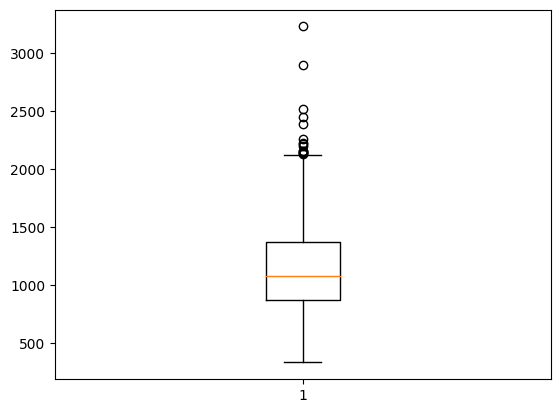

In [10]:
plt.boxplot(train['1st Flr SF']);
#its looking better, but we can still play with these if we are unhappy with our models performance

drop the unnecessary columns

In [12]:
def drop_col(data,col):
    """drop columns simply"""#it seems redundant but this is a prettier function for me than the built ins
    return data.drop(columns=col, axis =1, inplace=True)
#this made sense when I made it but didnt use it as much as I intended as my models were unhappy when I did

# Drop Id like its hot


In [13]:
drop_col(train,['Unnamed: 0','PID','Id'])
drop_col(test,['PID','Id'])

sorting out  our ohe columns, will make handling nulls and preprocessing earlier

In [14]:
#columns to ohe
ohe_cols=[col for col in train.columns if train[col].dtype == "object"]
ohe_cols=ohe_cols+['Mo Sold','MS SubClass'] #we might consider adding "quality" and "condition" columns

In [15]:
non_ohe_cols=[col for col in train.columns if col not in ohe_cols] #by process of elimination
non_ohe_cols # lets check through here again for any ordinals, nominals

['Lot Frontage',
 'Lot Area',
 'Overall Qual',
 'Overall Cond',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Yr Blt',
 'Garage Cars',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Misc Val',
 'Yr Sold',
 'SalePrice']

In [16]:
train[ohe_cols].nunique().sum() #how many columns is ohe going to add to our df, not too wild

273

# Handling missing values
Ill use "none" for all null categorical values, it will make it easier, and represent its own column when ohe. Missing values can have signifigant unique meaning per column, we can save the guessing as it likely wont change how its handled with few exception.

In [17]:
for col in ohe_cols:
    train[col].fillna('none', inplace=True)
    test[col].fillna('none', inplace=True)

train[ohe_cols].isnull().sum() #looks like we got them all, good job loop

/tmp/ipykernel_33/1191390651.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna('none', inplace=True)
/tmp/ipykernel_33/1191390651.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.met

MS Zoning         0
Street            0
Alley             0
Lot Shape         0
Land Contour      0
Utilities         0
Lot Config        0
Land Slope        0
Neighborhood      0
Condition 1       0
Condition 2       0
Bldg Type         0
House Style       0
Roof Style        0
Roof Matl         0
Exterior 1st      0
Exterior 2nd      0
Mas Vnr Type      0
Exter Qual        0
Exter Cond        0
Foundation        0
Bsmt Qual         0
Bsmt Cond         0
Bsmt Exposure     0
BsmtFin Type 1    0
BsmtFin Type 2    0
Heating           0
Heating QC        0
Central Air       0
Electrical        0
Kitchen Qual      0
Functional        0
Fireplace Qu      0
Garage Type       0
Garage Finish     0
Garage Qual       0
Garage Cond       0
Paved Drive       0
Pool QC           0
Fence             0
Misc Feature      0
Sale Type         0
Mo Sold           0
MS SubClass       0
dtype: int64

# Handle non categorical missing values

In [1008]:
need_vals_train=[col for col in non_ohe_cols if train[col].isnull().sum()>0]
need_vals_test=[col for col in non_ohe_cols if train[col].isnull().sum()>0]

train[need_vals_train].isnull().sum(),test[need_vals_test].isnull().sum() #we got a lot to sort out

(Lot Frontage      250
 Mas Vnr Area       17
 BsmtFin SF 1        1
 BsmtFin SF 2        1
 Bsmt Unf SF         1
 Total Bsmt SF       1
 Bsmt Full Bath      1
 Bsmt Half Bath      1
 Garage Yr Blt      88
 dtype: int64,
 Lot Frontage      77
 Mas Vnr Area       4
 BsmtFin SF 1       0
 BsmtFin SF 2       0
 Bsmt Unf SF        0
 Total Bsmt SF      0
 Bsmt Full Bath     0
 Bsmt Half Bath     0
 Garage Yr Blt     26
 dtype: int64)

#### Lot Frontage

We could use median or mean here, but lets check out the scatterplot and see if it will be appropriate and not disrupt our model too much. Keep in mind Lot Frontage is the amount of linear feet of street connected to property, so most properties will have it, and it shouldnt be too harmful if we select well

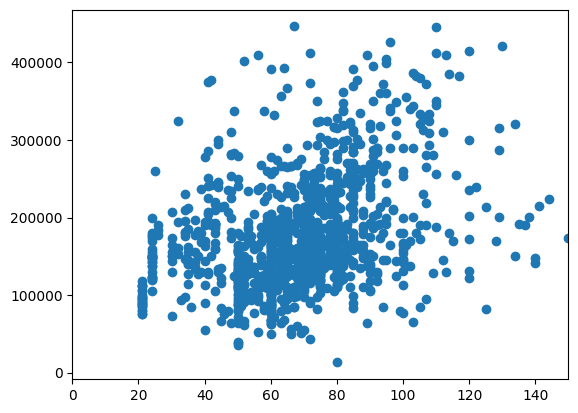

In [19]:
plt.scatter(train['Lot Frontage'], train['SalePrice']);
plt.xlim(0,150); #zoom zoom
#we have some outliers that escaped us,we might muck with these later

it looks like around 60-65 we have a good spread of sale prices that this is a good value without making too many problems, im going to pick 60 based on the visual, and its cheerful nature, but maybe we will go traditional with mean or median both of which are 68, if we are unhappy and want to try something else, should our model indicate.

In [21]:
train['Lot Frontage'].fillna(60, inplace=True)
test['Lot Frontage'].fillna(60, inplace=True);

/tmp/ipykernel_33/3310569289.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Lot Frontage'].fillna(60, inplace=True)
/tmp/ipykernel_33/3310569289.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

Lets see whats happenign with these missing basement values next. We see that for this one it is likely that no bsaement exists, hence the missing values,so replacing with 0s would be appropriate here.

In [24]:
need_fil_0=['BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF','Bsmt Full Bath','Bsmt Half Bath']
for col in need_fil_0:
    train[col].fillna(0, inplace=True)

/tmp/ipykernel_33/920942154.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(0, inplace=True)


Lets handle garage and mas vnr area, we see the missing mas vnr area, or properties that have no mas vnr area so we will replace these with 0. The Garabge Problem is a little differen and we might actually want to experiment with dropping this column, but lets fill it with something reasonable for now.

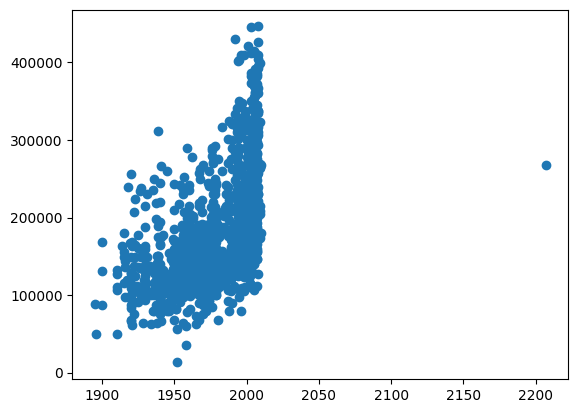

In [28]:
plt.scatter(train['Garage Yr Blt'], train['SalePrice']);
#woah we ahve a garage from the future!

In [39]:
train[train['Garage Yr Blt']>2020]['Garage Yr Blt']

1098    2207.0
Name: Garage Yr Blt, dtype: float64

In [43]:
train['Garage Yr Blt'].replace(2207.0, 2007, inplace=True) #okay they probably meant 2007 and not 2207

/tmp/ipykernel_33/1973847042.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Garage Yr Blt'].replace(2207.0, 2007, inplace=True)


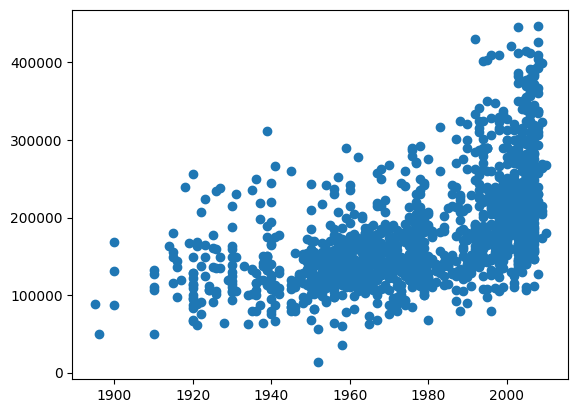

In [45]:
plt.scatter(train['Garage Yr Blt'], train['SalePrice']); #thats better
#Im going to pick 1950 a simpler time, that should reward or penalize these missing values too much
#we might still just drop, since there isnt a good solution here


In [46]:
train['Garage Yr Blt'].fillna(1950, inplace=True)
test['Garage Yr Blt'].fillna(1950, inplace=True)
train['Mas Vnr Area'].fillna(0, inplace=True)
test['Mas Vnr Area'].fillna(0, inplace=True)

/tmp/ipykernel_33/4043700131.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Garage Yr Blt'].fillna(1950, inplace=True)
/tmp/ipykernel_33/4043700131.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

# All clean time to ohe

In [47]:
ohe=OneHotEncoder(sparse_output = False,handle_unknown = 'ignore').set_output(transform='pandas')
transformed=ohe.fit( train[ohe_cols])
transformed=ohe.transform( train[ohe_cols])

transformed_test=ohe.transform( test[ohe_cols])

In [48]:

test_non_ohe_cols=[col for col in non_ohe_cols if col != "SalePrice"]


In [49]:
y=train['SalePrice'] #seperate out our label

In [51]:
#merge baby merge
train_ohe = pd.merge(train[non_ohe_cols], transformed, left_index=True, right_index=True)
test_ohe = pd.merge(test[test_non_ohe_cols], transformed_test, left_index=True, right_index=True)

train_ohe.shape #just checkin, baby looks good

(1511, 323)

In [53]:
#Forgot about these, oops
train_ohe['Garage Cars'].fillna(0, inplace=True)
train_ohe['Garage Area'].fillna(0, inplace=True)
test_ohe['Garage Cars'].fillna(0, inplace=True)
test_ohe['Garage Area'].fillna(0, inplace=True)

/tmp/ipykernel_33/3429581649.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_ohe['Garage Cars'].fillna(0, inplace=True)
/tmp/ipykernel_33/3429581649.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [52]:
X=train_ohe.copy() #incase we want to play with different versions
X.shape #so handsome

(1511, 323)

# Feature engineering

so thrilling, can you feel the excitement, lets see if we can create some more data points for our model to get wild with

In [54]:
#this wont hurt any, and I dont have the time to be running polynomial features, 
#I noticed a parabolic nature to the years v saleprice and condition,
X['Year Built2']= X['Year Built']**2
X['Year Remod/Add2']= X['Year Remod/Add']**2
test_ohe['Year Built2']= test_ohe['Year Built']**2
test_ohe['Year Remod/Add2']= test_ohe['Year Remod/Add']**2
 
X['Overall Cond2']= X['Overall Cond']**2
test_ohe['Overall Cond2']= test_ohe['Overall Cond']**2

# we dont really have a column for the simple questions of presence of feature for these, so why not
X['Has Bsmt'] = X['Total Bsmt SF'].apply(lambda x: 1 if x > 0 else 0)
test_ohe['Has Bsmt'] = test_ohe['Total Bsmt SF'].apply(lambda x: 1 if x > 0 else 0)

X['Has Garage'] = X['Garage Area'].apply(lambda x: 1 if x > 0 else 0)
test_ohe['Has Garage'] = test_ohe['Garage Area'].apply(lambda x: 1 if x > 0 else 0)

X['Has 2nd Flr'] = X['2nd Flr SF'].apply(lambda x: 1 if x > 0 else 0)
test_ohe['Has 2nd Flr'] = test_ohe['2nd Flr SF'].apply(lambda x: 1 if x > 0 else 0)


#sq footage and some other redundant data is organized weird, no one would look at houses like this, 
#so lets concat these to a single value
X['Total Bathrooms'] = X['Bsmt Full Bath'] + 0.5*X['Bsmt Half Bath'] + X['Full Bath'] + 0.5*X['Half Bath']
X['Total Porch SF'] =   X['Open Porch SF'] + X['Enclosed Porch'] + X['3Ssn Porch'] + X['Screen Porch']
X['Total SF'] = X['Total Bsmt SF'] + X['1st Flr SF'] + X['2nd Flr SF']
#the test too
test_ohe['Total Bathrooms'] = test_ohe['Bsmt Full Bath'] + 0.5*test_ohe['Bsmt Half Bath'] + test_ohe['Full Bath'] + 0.5*test_ohe['Half Bath']
test_ohe['Total Porch SF'] =   test_ohe['Open Porch SF'] + test_ohe['Enclosed Porch'] + test_ohe['3Ssn Porch'] + test_ohe['Screen Porch']
test_ohe['Total SF'] = test_ohe['Total Bsmt SF'] + test_ohe['1st Flr SF'] + test_ohe['2nd Flr SF']

#we could drop to handle multi collinearity but we have Lasso on our side, we can trust our models to do what is best

In [55]:
y=X['SalePrice']
X=X.drop(columns=["SalePrice"]) #lets remove our label from our features now that we are ready to model

# Model time

Lets start with stats model so we can see how features our valued their p value will help us make assessments about important features on house sale price, this is part of our big question after all

In [191]:
model = sm.OLS(y,X) 
results = model.fit()
results_summary=results.summary()
# we want to be able to play with the model summary, so lets transform it to something easier to work with
results_as_html = results_summary.tables[1].as_html() 
oldf=pd.read_html(results_as_html, header=0, index_col=0)[0] 
results_summary

/tmp/ipykernel_33/2112652107.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  oldf=pd.read_html(results_as_html, header=0, index_col=0)[0]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     80.38
Date:                Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                        04:02:23   Log-Likelihood:                -16764.
No. Observations:                1511   AIC:                         3.408e+04
Df Residuals:                    1237   BIC:                         3.553e+04
Df Model:                         273                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Lot Frontage           108.3455     35.804      3.026      0.003      38.103     178.588
Lot Area                 0.9736      0.187      5.201      0.000       0.606       1.341
Overall Qual          6488.2717    807.773      8.032      0.000    4903.515    8073.029
Overall Cond          7699.0612   3621.549      2.126      0.034     594.004    1.48e+04
Year Built           -5358.4893   4699.956     -1.140      0.254   -1.46e+04    3862.277
Year Remod/Add       -1.069e+04   1.08e+04     -0.987      0.324    -3.2e+04    1.06e+04
Mas Vnr Area            15.4973      4.916      3.152      0.002       5.852      25.142
BsmtFin SF 1            11.4507      2.223      5.151      0.000       7.089      15.812
BsmtFin SF 2            -4.5949      4.147     -1.108      0.268     -12.730       3.540
Bsmt Unf SF             -4.8744      2.176     -2.240      0.025      -9.144      -0.605
Total Bsmt SF            1.9956      3.138      0.636      0.525      -4.160       8.151
1st Flr SF               6.3654      3.707      1.717      0.086      -0.908      13.639
2nd Flr SF              12.8594      3.794      3.390      0.001       5.417      20.302
Low Qual Fin SF          1.5623      8.312      0.188      0.851     -14.744      17.869
Gr Liv Area             20.7884      4.634      4.486      0.000      11.698      29.879
Bsmt Full Bath        3233.4857   1125.455      2.873      0.004    1025.475    5441.497
Bsmt Half Bath        3174.4733   2039.480      1.557      0.120    -826.750    7175.696
Full Bath            -2192.7699   1249.345     -1.755      0.079   -4643.839     258.299
Half Bath            -1133.5784   1417.246     -0.800      0.424   -3914.051    1646.894
Bedroom AbvGr        -2519.2120   1052.028     -2.395      0.017   -4583.168    -455.256
Kitchen AbvGr        -9369.9450   5036.571     -1.860      0.063   -1.93e+04     511.221
TotRms AbvGrd            9.0733    748.003      0.012      0.990   -1458.421    1476.568
Fireplaces            3469.1732   2185.862      1.587      0.113    -819.233    7757.580
Garage Yr Blt           45.6532     49.817      0.916      0.360     -52.081     143.387
Garage Cars           4278.0202   1904.479      2.246      0.025     541.653    8014.387
Garage Area              6.6476      6.530      1.018      0.309      -6.164      19.459
Wood Deck SF             8.5566      4.725      1.811      0.070      -0.713      17.826
Open Porch SF           -6.2025      8.542     -0.726      0.468     -22.961      10.556
Enclosed Porch          -6.0721      8.654     -0.702      0.483     -23.050      10.906
3Ssn Porch              11.4881     15.335      0.749      0.454     -18.597      41.573
Screen Porch            21.1263      8.817      2.396      0.017       3.828      38.425
Pool Area             -227.5210     99.115     -2.296    

Lets see if our model feels better dropping some of these poorly correlated columns

In [69]:
X_drop=X.drop(columns="Garage Yr Blt")
test_d=test_ohe.copy().drop(columns="Garage Yr Blt") # lets see if its better witout garage yr blt, 
#that was a weird one

In [70]:
testsmdrop=oldf[oldf['P>|t|']>0.95].index.to_list()
testsmdrop # lets see if we want to drop anyone else

['TotRms AbvGrd']

In [71]:
for col in testsmdrop:
    drop_col(X_drop,col)
    drop_col(test_d,col)

In [72]:
model2 = sm.OLS(y,X)
results = model2.fit()
results.summary() #not much difference we see, may as well keep them all and let the models sort them out

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     80.38
Date:                Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                        03:15:36   Log-Likelihood:                -16764.
No. Observations:                1511   AIC:                         3.408e+04
Df Residuals:                    1237   BIC:                         3.553e+04
Df Model:                         273                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Lot Frontage           108.3455     35.804      3.026      0.003      38.103     178.588
Lot Area                 0.9736      0.187      5.201      0.000       0.606       1.341
Overall Qual          6488.2717    807.773      8.032      0.000    4903.515    8073.029
Overall Cond          7699.0612   3621.549      2.126      0.034     594.004    1.48e+04
Year Built           -5358.4893   4699.956     -1.140      0.254   -1.46e+04    3862.277
Year Remod/Add       -1.069e+04   1.08e+04     -0.987      0.324    -3.2e+04    1.06e+04
Mas Vnr Area            15.4973      4.916      3.152      0.002       5.852      25.142
BsmtFin SF 1            11.4507      2.223      5.151      0.000       7.089      15.812
BsmtFin SF 2            -4.5949      4.147     -1.108      0.268     -12.730       3.540
Bsmt Unf SF             -4.8744      2.176     -2.240      0.025      -9.144      -0.605
Total Bsmt SF            1.9956      3.138      0.636      0.525      -4.160       8.151
1st Flr SF               6.3654      3.707      1.717      0.086      -0.908      13.639
2nd Flr SF              12.8594      3.794      3.390      0.001       5.417      20.302
Low Qual Fin SF          1.5623      8.312      0.188      0.851     -14.744      17.869
Gr Liv Area             20.7884      4.634      4.486      0.000      11.698      29.879
Bsmt Full Bath        3233.4857   1125.455      2.873      0.004    1025.475    5441.497
Bsmt Half Bath        3174.4733   2039.480      1.557      0.120    -826.750    7175.696
Full Bath            -2192.7699   1249.345     -1.755      0.079   -4643.839     258.299
Half Bath            -1133.5784   1417.246     -0.800      0.424   -3914.051    1646.894
Bedroom AbvGr        -2519.2120   1052.028     -2.395      0.017   -4583.168    -455.256
Kitchen AbvGr        -9369.9450   5036.571     -1.860      0.063   -1.93e+04     511.221
TotRms AbvGrd            9.0733    748.003      0.012      0.990   -1458.421    1476.568
Fireplaces            3469.1732   2185.862      1.587      0.113    -819.233    7757.580
Garage Yr Blt           45.6532     49.817      0.916      0.360     -52.081     143.387
Garage Cars           4278.0202   1904.479      2.246      0.025     541.653    8014.387
Garage Area              6.6476      6.530      1.018      0.309      -6.164      19.459
Wood Deck SF             8.5566      4.725      1.811      0.070      -0.713      17.826
Open Porch SF           -6.2025      8.542     -0.726      0.468     -22.961      10.556
Enclosed Porch          -6.0721      8.654     -0.702      0.483     -23.050      10.906
3Ssn Porch              11.4881     15.335      0.749      0.454     -18.597      41.573
Screen Porch            21.1263      8.817      2.396      0.017       3.828      38.425
Pool Area             -227.5210     99.115     -2.296    

# Train test split

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .3,random_state=141)


In [176]:
def get_fit_score(model,Xs,Ys):
    model1=model.fit(Xs, Ys)
    print(f'{model}\n test score: {model1.score(X_test,y_test)}\n train score: {model1.score(X_train,y_train)}')
    y_pred=model1.predict(X)
    print(f'mean squared error: {mean_squared_error(y,y_pred, squared=False)}')

    return model1

In [177]:
lr=get_fit_score(LinearRegression(),X_train,y_train)

LinearRegression()
 test score: 0.8938762661808299
 train score: 0.9532014111864606
mean squared error: 17436.960241299206


get our Linear Regression model coefficient values to compare to our Stats Model above to answer our questions about features that impact our sales price

In [144]:
top_lr=pd.DataFrame(lr.coef_,X.columns).sort_values(by=0) 
top_lr

,0
Pool QC_none,-104206.197685
Misc Feature_TenC,-70410.452854
MS SubClass_150,-58974.037102
Roof Style_Mansard,-44033.827805
Exterior 2nd_CBlock,-37520.141231
...,...
MS SubClass_45,43929.484884
Condition 2_PosA,46785.093082
Pool QC_Gd,51600.557125
Pool QC_Fa,67236.694501


In [182]:
piper=Pipeline([("scale",StandardScaler()),               
               ("model",Ridge(alpha = .0,fit_intercept = True, max_iter = 10000, solver='saga'))])


In [183]:
get_fit_score(piper,X_train,y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('model', Ridge(alpha=0.0, max_iter=10000, solver='saga'))])
 test score: 0.895172369352797
 train score: 0.9531234319228046
mean squared error: 17393.2852330265


Pipeline(steps=[('scale', StandardScaler()),
                ('model', Ridge(alpha=0.0, max_iter=10000, solver='saga'))])

In [164]:
pipelas=Pipeline([
    ("scale",MinMaxScaler()), # choosin minmax over standard scaler, to help resolve all those weird outliers we saw earlier
               ("model", LassoCV(
                                 max_iter=100000,random_state=212, cv=8
                                )
)])
# Lasso(alpha=0.0001, fit_intercept=True, max_iter=10000) # a relic from a less accuract model

In [184]:
get_fit_score(pipelas,X_train,y_train)

Pipeline(steps=[('scale', MinMaxScaler()),
                ('model', LassoCV(cv=8, max_iter=100000, random_state=212))])
 test score: 0.9027407166918722
 train score: 0.9358270353960711
mean squared error: 18721.150431648806


Pipeline(steps=[('scale', MinMaxScaler()),
                ('model', LassoCV(cv=8, max_iter=100000, random_state=212))])

Our LassoCV model has a worse rmse, but we see its test score is higher with less overfitting then our LR or Ridge model, and this will be more valuable when running on an unknown test set, so we will use this one.
Our LassoCV out performed our Lasso signifigantly, and out performed our Ridge and Linear Regression, so it will be our best model to use for competition submission.

# Running our model on the test data
and creating an output CSV for submission and memories

In [185]:
pipelas.fit(X,y)

Pipeline(steps=[('scale', MinMaxScaler()),
                ('model', LassoCV(cv=8, max_iter=100000, random_state=212))])

In [186]:
preds_test = pipelas.predict(test_ohe)
output = pd.DataFrame({'Unnamed: 0': test['Unnamed: 0'],
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)